# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [1]:
import pandas as pd                                 
import numpy as np         
import time
import random

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer

import seaborn as sns

RANDOM_STATE=42

import warnings 
warnings.filterwarnings('ignore')

## Загрузка данных и EDA

In [2]:
data = pd.read_csv(r'C:\Users\Grine\Desktop\GitHub\YandexPracticum\4 ВВЕДЕНИЕ В МАШИННОЕ ОБУЧЕНИЕ\users_behavior.csv') 

In [3]:
df = data.copy() 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


**Целевая переменная имеет среднее значение 0.3. Это напярмую говорит о дисбалансе классов. При последующем Моделирование мы будем учитывать дисбаланс классов.**

In [6]:
df.corr(method='spearman')

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.978684,0.155032,0.253886,0.160549
minutes,0.978684,1.000000,0.153784,0.248818,0.159991
messages,0.155032,0.153784,1.000000,0.141999,0.106537
mb_used,0.253886,0.248818,0.141999,1.000000,0.154989
is_ultra,0.160549,0.159991,0.106537,0.154989,1.000000


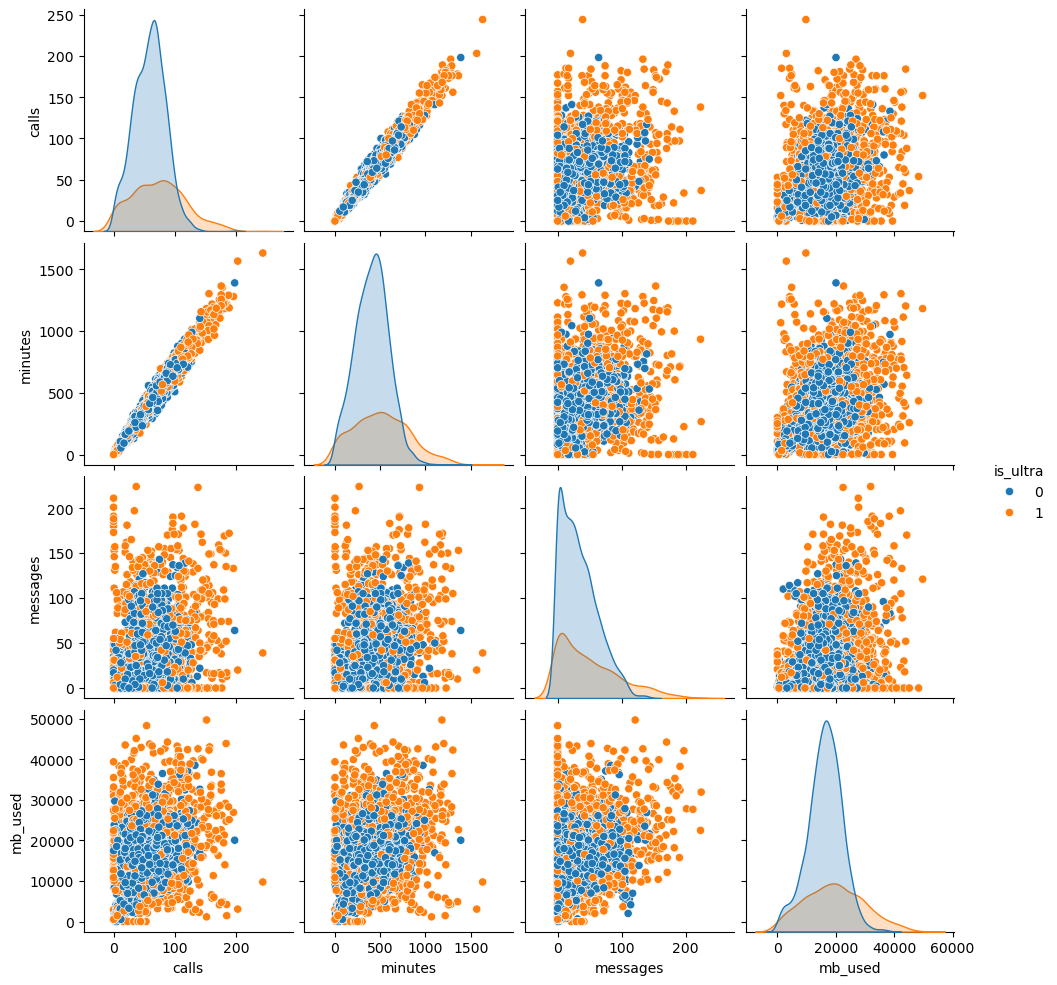

In [7]:
sns.pairplot(df, hue='is_ultra');

**Промежуточные выводы:**

    1. Типы данных корректны; 
    2. Статистические выбросы - незамечены;
    3. Есть дисбаланс классов;
    4. Признаки minutes и calls - мультиколениарны (по признаку корреляции и эмперически на уровне графиков).


## Разобьём данные на выборки для обучения, валидации и тестирования

In [8]:
# разделим наши данные на обучающий набор данных и целевой признак
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.4, random_state=RANDOM_STATE, stratify=target)


X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=RANDOM_STATE, stratify=y_test)

# проверим как сохранилось процентное соотношение 3 итоговых выборок 
print('Объём выборки для обучения:', "{0:.0%}".format(X_train.shape[0]/df.shape[0]))
print('Объём выборки для валидации:', "{0:.0%}".format(X_val.shape[0]/df.shape[0]))
print('Объём выборки для теста:', "{0:.0%}".format(X_test.shape[0]/df.shape[0]))

Объём выборки для обучения: 60%
Объём выборки для валидации: 20%
Объём выборки для теста: 20%


## Исследуем Модель

**Проведём тестирование Моделей:**    
    
    1) Древо решений (tree - в дальнейшем в проекте)
    2) Случайный лест (random - в дальнейшем в проекте)
    3) Логистическая регрессия (log_reg - в дальнейшем в проекте)
    
В условиях задания указано, что мы должны минимизировать метрику accuracy, тем не менее, мы можем наблюдать явный дисбаланс классов, что значительно снижает эффективность данной метрики. Предлагается минимизировать метрику f1.

Поскольку данных мало мы будем использовать gridsearch.

### Построим BASELINE Модель

In [10]:
baseline_model = LogisticRegression(random_state=RANDOM_STATE)
baseline_model.fit(X_train, y_train)

preds = baseline_model.predict(X_val)

print('Оценка f1 на базовой Модели: {:.2f}'.format(f1_score(preds, y_val)))

Оценка f1 на базовой Модели: 0.10


In [11]:
# инициируем метрику для проверки в сетках параметров
f1 = make_scorer(f1_score, average='macro')

**Значение f1 - меры мы будем использовать как бенчмарк.**

### Древо решений

In [12]:
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]

}

model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, 
                                    class_weight='balanced')

clf_tree = GridSearchCV(
    estimator=model_tree,
    param_grid=param_grid_tree,
    scoring=f1,
    n_jobs=-1,
    cv=3
)

clf_tree.fit(X_train, y_train)


print('Лучший результат F1-меры: {:.2f}'.format(clf_tree.best_score_))
print('Лучшие параметры: \n', clf_tree.best_params_)

Лучший результат F1-меры: 0.74
Лучшие параметры: 
 {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}


*Модель уже сильно лучше бенчмарка. В целом, мы уже скорей всего достигли поставленной цели. Также эта модель хороша тем, что легко интерпретируема и быстра.*

### Случайный лес

In [13]:
param_grid_random = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]

}

model_random = RandomForestClassifier(random_state=RANDOM_STATE, 
                                      class_weight='balanced')

clf_random = GridSearchCV(
    estimator=model_random,
    param_grid=param_grid_random,
    scoring=f1,
    n_jobs=-1,
    cv=3
)

clf_random.fit(X_train, y_train)


print('Лучший результат F1-меры: {:.2f}'.format(clf_random.best_score_))
print('Лучшие параметры: \n', clf_random.best_params_)

Лучший результат F1-меры: 0.76
Лучшие параметры: 
 {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


*Модель случайного леса ещё лучше справляется с поставленной задачей!*

### Логистическая регрессия

In [26]:
param_grid_log_reg = {
    'solver': ['liblinear'],
    'penalty': ['l1','l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

model_log_reg = LogisticRegression(random_state=RANDOM_STATE, 
                                   class_weight='balanced')

clf_log_reg = GridSearchCV(
    estimator=model_log_reg,
    param_grid=param_grid_log_reg,
    scoring=f1,
    n_jobs=-1,
    cv=3
)

clf_log_reg.fit(X_train, y_train)


print('Лучший результат F1-меры: {:.2f}'.format(clf_log_reg.best_score_))
print('Лучшие параметры: \n', clf_log_reg.best_params_)

Лучший результат F1-меры: 0.60
Лучшие параметры: 
 {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


*А вот логистическая регрессия плохо справляется с поставленной задачей. В целом, изначальные предпоссылки (мультиколенниарный признак, отсуствие линейного разделения целевой переменной по признакам) - об этом свидетельствовали, но проверить стоило*

Для проверки модели на трёх выборках будем использовать 3 параметра (затем переведём их в дата-фрейм и выделим лучшую модель):
    
    1) accuracy_score - оценка правильности. (% правильных ответов);
    2) recall_score - доля объектов положительного класса из всех объектов положительного класса. (сколько положительных результатов из всех результатов);
    3) average_precision_score - средняя доля объектов, названных классификатором положительными (средняя точность результатов прогнозирования);
    4) roc_auc_score - Площадь под кривой рабочих характеристик приемника (ROC AUC) по результатам прогнозирования.
    
*Для каждой из этих метрик, лучшим результатом будет "1", а худшим "0"*

**Вывод:**

Лучшей Моделью оказался случайный лес, с параметрами:
    {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Далее мы проведем дополнительное тестирование Этой Модели на тестовой выборке

## Проверка лучшей Модели

In [54]:
model = clf_random.best_estimator_
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred = model.predict(X_test)


accuracy_train = accuracy_score(y_train, pred_train)
recall_train = recall_score(y_train, pred_train)
average_precision_train = average_precision_score(y_train, pred_train)
roc_auc_train = roc_auc_score(y_train, pred_train)


accuracy_test = accuracy_score(y_test, pred)
recall_test = recall_score(y_test, pred)
average_precision_test = average_precision_score(y_test, pred)
roc_auc_test = roc_auc_score(y_test, pred)

results = pd.DataFrame({
        'accuracy': [accuracy_train, accuracy_test],
        'recall': [recall_train, recall_test],
        'average_precision': [average_precision_train, average_precision_test],
        'roc_auc': [roc_auc_train, roc_auc_test]
    }, index=['dev', 'test']).round(2)

results.loc['delta'] = np.round([accuracy_train - accuracy_test, recall_train - recall_test, average_precision_train - average_precision_test, roc_auc_train - roc_auc_test], 2)
results

,accuracy,recall,average_precision,roc_auc
dev,0.85,0.69,0.64,0.81
test,0.79,0.62,0.53,0.74
delta,0.06,0.07,0.11,0.06


*Результаты метрик корректны и соотвествуют поставленным требованиям, мы также можем наблюдать, что Модель не перееобучается. Посмотрим также важность призанков*

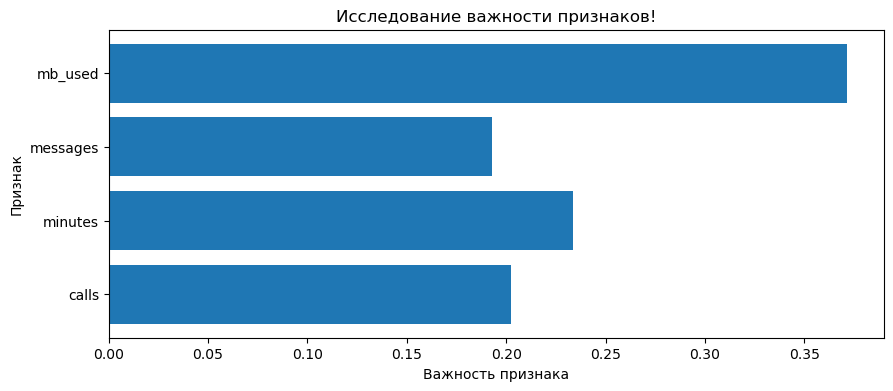

In [69]:
plt.figure(figsize=(10, 4))
n_features = X_train.shape[1]
plt.barh(range(n_features), model.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Важность признака")
plt.ylabel("Признак")
plt.title('Исследование важности признаков!')
plt.show();

*Наиболее важными признаками являются признаки mb_used и minutes - что не противоречит бизнес логике!*

## Общий вывод

В результате, мы обучили Модели Случайного Леса и нашли оптимальные гиперетпараметры, которые в наибольшей степени отвечают заданным условиям. Теперь мы можем эффективно рекомендовать тарифы!